In [5]:
import numpy as np
import json
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from FastMap import FastMap, show_cluster, distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from radar import radar_plt

In [6]:
data = np.load('../data/vec_data.npz')

## Finding Specialties of Universities

In the previous parts, we have already obtained the document embedding of the alumni and the disciplines. We have also compared universities across different disciplines. In this part, we compare the strengths of the same university in different disciplines, i.e., their specialties.

### Data Preprocessing

To find the specialties of universities, we first organize the document vectors of all the alumni into a single matrix and label them with the universities they belong to. We also need to normalize the document vectors for further processing.

In [7]:
vectors = []
labels = []
names = []
univs = []

for idx, label in enumerate(data):
    univ = data[label][()]
    univs.append(label)
    for name in univ:
        vectors.append(univ[name])
        labels.append(idx)
        names.append(name)
        
vectors = np.asarray(vectors)
vectors = normalize(vectors)

### Clustering of Alumni

We then perform an unsupervised learning on the document vectors of alumni, namely, we cluster the alumni vectors into 100 clusters using Kmeans. The assumption here is that alumni in similar disciplines will have document vectors with larger cosine similarities (after normalization, cosine similarity equals Euclidean distance). If such is the case, we would expect that the alumni corresponding to vectors in a cluster found would be in similar disciplines.

In [8]:
k = 100
kmeans = KMeans(n_clusters=k, random_state=0).fit(vectors)

### Labeling of Clusters

Since clustering is an unsupervied learning task, we have no information about which discipline each cluster corresponds to after performing Kmeans. Rather than finding this out manually, we use the document embedding of the 21 disicpline articles again. We first find the mean of the document vectors in each cluster.

In [9]:
count = np.zeros((len(univs), k))

cluster = {}
cluster_vec = np.zeros((k, vectors.shape[1]))
for i in range(k):
    cluster[i] = []

for (idx, (univ, clst)) in enumerate(zip(labels, kmeans.labels_)):
    count[univ][clst] += 1
    cluster[clst].append(names[idx])
    cluster_vec[clst] += vectors[idx]

cluster_vec = cluster_vec / np.sum(count, axis=0)[:, None]

with open('cluster.json', 'w') as fp:
    json.dump(cluster, fp)

We then normalize the document vectors of the discipline articles. In this way, we get two matrices, one for the means of the alumni clusters and one for the disciplines. We use our assumption again that the cosine similarity between an alumni document and a discipline document indicates the association of the alumni to the discipline. We find the cosine similarity matrix between these two matrices and take the discipline that cluster the mean is closest to as the label of the cluster.

In [10]:
discipline = np.load('../data/vec_discipline.npz')

In [11]:
discipline_vec = []
discs = []

for idx, disc in enumerate(discipline):
    discipline_vec.append(discipline[disc])
    discs.append(disc)
        
discipline_vec = np.asarray(discipline_vec)
discipline_vec = normalize(discipline_vec)

In [12]:
cos_sim = 1 - pairwise_distances(cluster_vec, discipline_vec, metric="cosine")
cos_sim = normalize(cos_sim, axis=0)
tags = np.argmax(cos_sim, axis=1)

In [13]:
rcount = np.zeros((len(univs), len(discs)))
rcluster = {}
rlabels = []

for i in discs:
    rcluster[i] = []

for idx in range(k):
    for univ in range(len(univs)):
        rcount[univ][tags[idx]] += count[univ][idx]
    rcluster[discs[tags[idx]]] += cluster[idx]

for label in kmeans.labels_:
    rlabels.append(tags[label])

with open('rcluster.json', 'w') as fp:
    json.dump(rcluster, fp)

### Discipline Cluster Results

We have already tagged each alumnus with their discipline chosen from the 21 main disciplines given by Wikipedia. Let us inspect tagging of several alumni to see the effect of the unsupervised learning.

In [31]:
t = 20
P = np.random.randint(0, len(names), t)
for p in P:
    print(names[p] +  ':\t' + discs[rlabels[p]])

Lee Reherman:	Languages and literature
Ken Mehlman:	Economics
Neo Kian Hong:	Law
Jonathan Shewchuk:	Mathematics
Joel H. Rosenthal:	Economics
Edward Clark Carter:	Economics
Theodore Lightner:	Earth sciences
Jerrold Meinwald:	Mathematics
Michael Bicay:	Earth sciences
Frits van Paasschen:	Economics
Mathea Falco:	Medicine and health
Carl Jockusch:	Mathematics
Burt Z. Kasson:	Law
Peter Buffett:	Arts
Shelley E. Taylor:	Mathematics
H. V. Jagadish:	Computer Science
Zack Norman:	Arts
Christopher Edwards (author):	Languages and literature
Audrey Wells:	Arts
William H. Phelps Sr.:	Law


In the results, we manually find that most of the alumni are assigned correct tags of discipline, indicating that the assumptions of this model are reasonable. However, some alumni tagged with some minor disciplines are misclasified. This is due to that there are too little information for these minor disciplines, and several clusters are mislabled.

We can also plot the alumni vectors colored with their asscociated disciplines. In this part, we use FastMap, PCA, and TSNE to reduce the dimension of the vectors to 2d and plot them out with disciplines.

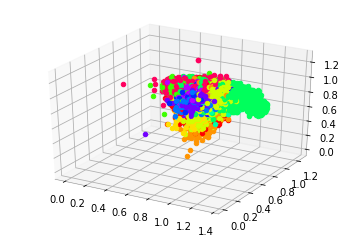

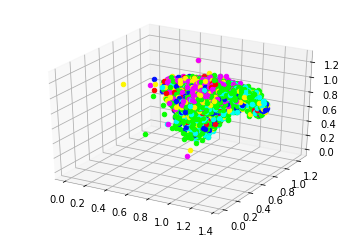

In [13]:
d = 2
dist = euclidean_distances(vectors, vectors)
X2, _ = FastMap(d, dist, vectors.shape[0])
show_cluster(X2, rlabels, d)
show_cluster(X2, labels, d)

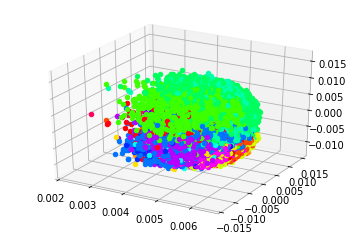

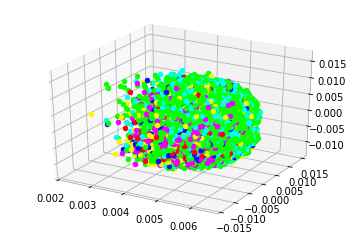

In [14]:
d = 2
pca = PCA(n_components=d)
pca.fit_transform(vectors.T)
show_cluster(pca.components_.T, rlabels, d)
show_cluster(pca.components_.T, labels, d)

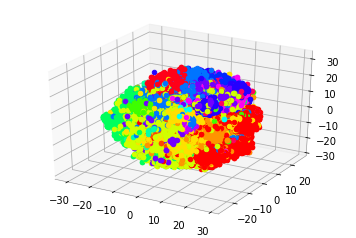

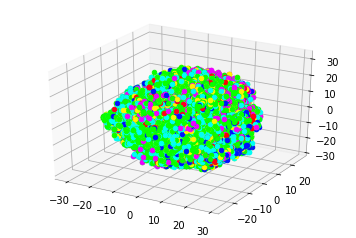

In [12]:
d = 2
tsne = TSNE(n_components=d, random_state=0)
tsne.fit_transform(vectors)
show_cluster(tsne.embedding_, rlabels, d)
show_cluster(tsne.embedding_, labels, d)

Scatter plots obtained by all of the three dimensionality reduction algorithms show some structure of the discipline clusters, further verifying our assumption that document vectors of alumni in similar disciplines have larger cosine similarities.

### Specialties of Universities

With each alumni cluster tagged with a discipline, we can then find the number of alumni in a specific discipline for each university. This time, we assume that the number of alumni in a specific discipline indicates the strength of the university in that disicipline.

We assign the strength of the discipline with the most alumni to be 100 for each university. The strength of other universities are assigned proportional to the number of alumni with respect to the strongest discipline.

We plot the strength of all disciplines in a radar plot for each university.

In [10]:
strength = normalize(rcount, axis=0)
strength /= np.max(strength, axis=1)[:, None]
strength *=  100

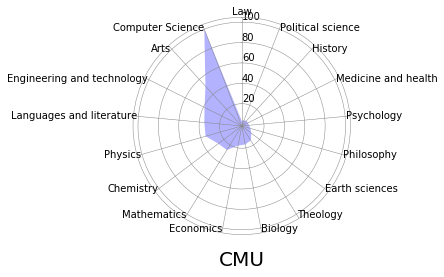

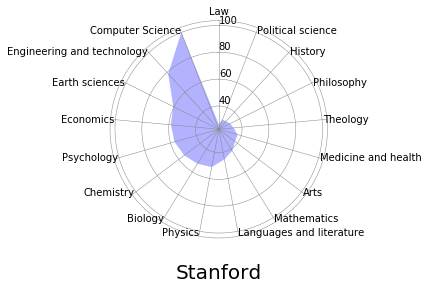

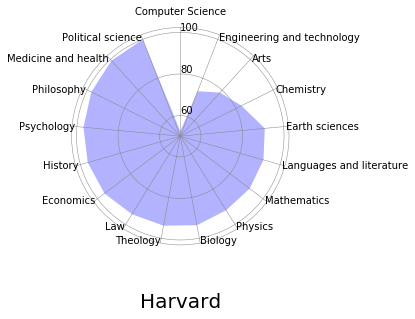

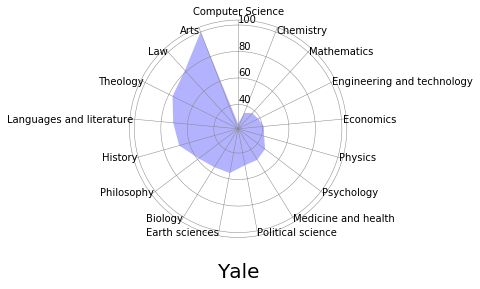

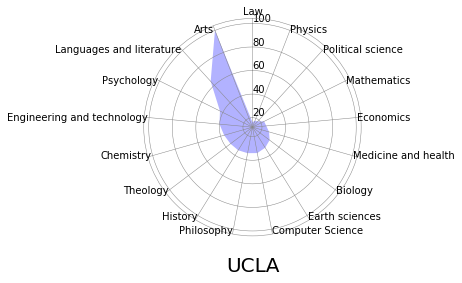

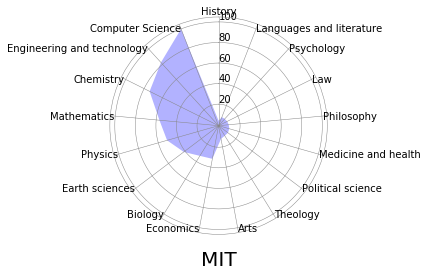

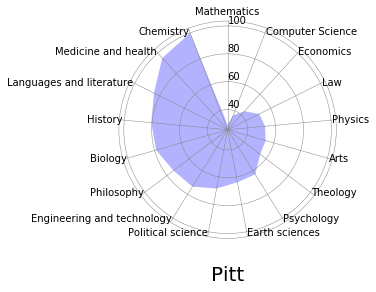

In [11]:
for j in range(strength.shape[0]):
    values = strength[j]
    idxs = np.argsort(values)
    cat = [discs[i] for i in idxs]
    values = np.sort(values)
    tail = len(values) - len(np.nonzero(values)[0])
    cat = cat[tail:]
    values = list(values[tail:])
    radar_plt(cat, values, univs[j])

From the radar plots, we find that CMU is specialized in Computer Science, Arts, and Engineering, which is reasonable. MIT is strong in basically all engineering and application science but relatively weak in liberal arts. University of Pittsburg is strong in chemistry and medicine. Harvard is strong and balanced in all non-engineering disciplines. All these coincides with basic facts and the public's impression on these universities. The result for other universities are also sound.